In [1]:
# pip install kagglehub
# pip install nltk
# pip install wordcloud
# pip install hnswlib

In [2]:
import pandas as pd 
import numpy as np
import os
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Clusttering DM 

In [3]:
path = "data/"

In [4]:
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]

In [5]:
for file in csv_files:
    var_name = file.replace(".csv", "").replace(" ", "_")
    globals()[var_name] = pd.read_csv(f"{path}{file}")

In [6]:
# Combined_Jobs_Final
# Job_Views
# job_data
# Positions_Of_Interest
# Experience

## Part 1: Clustering Jobs Based on Descriptions

### 1. Data Clearning

In [7]:
# Use datasets
df_jobs = Combined_Jobs_Final[['Job.ID', 'Title', 'Position', 'Company', 'Industry', 'Job.Description']].copy()
df_users = Positions_Of_Interest[['Applicant.ID', 'Position.Of.Interest']].copy()

In [8]:
df_jobs.head(3)

,Job.ID,Title,Position,Company,Industry,Job.Description
0,111,Server @ Tacolicious,Server,Tacolicious,Food and Beverages,Tacolicious' first Palo Alto store just opened...
1,113,Kitchen Staff/Chef @ Claude Lane,Kitchen Staff/Chef,Claude Lane,Food and Beverages,\r\n\r\nNew French Brasserie in S.F. Financia...
2,117,Bartender @ Machka Restaurants Corp.,Bartender,Machka Restaurants Corp.,Food and Beverages,We are a popular Mediterranean wine bar and re...


In [9]:
df_jobs.shape

(84090, 6)

### 2.Preprocessing Job Descriptions (NLTK)

In [10]:
# import nltk
# nltk.download()

In [11]:
# Ensure necessary NLTK data is downloaded
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/gracelam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gracelam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gracelam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
import html
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Updated Preprocessing Function
def preprocess_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    
    # HTML Decode
    text = html.unescape(text)

    # Remove non-alphabetic words (e.g., `nbsp`, `rsquo`)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize words
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum()]  # Remove punctuation
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    
    return " ".join(words)

In [13]:
# Apply preprocessing to Job Descriptions

from tqdm import tqdm

tqdm.pandas() 
df_jobs['Cleaned_Description'] = df_jobs['Job.Description'].astype(str).progress_apply(preprocess_text)

100%|███████████████████████████████████| 84090/84090 [01:22<00:00, 1013.86it/s]


### 3.TFIDF

In [14]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=500)  # Limit features for efficiency
X = vectorizer.fit_transform(df_jobs['Cleaned_Description'])

### 4. Elbow method

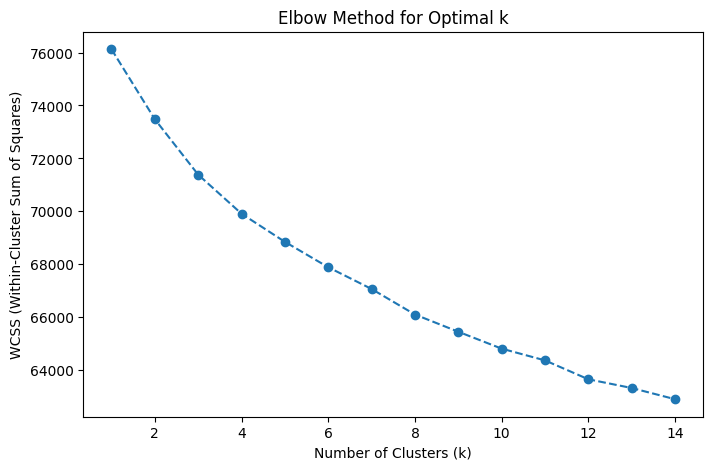

In [15]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Find the optimal number of clusters using the Elbow Method
wcss = []
K_range = range(1, 15)  # Testing clusters from 1 to 14

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Store within-cluster sum of squares (WCSS)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o', linestyle='--')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.title("Elbow Method for Optimal k")
plt.show()

### 5.Apply K-Means Clustering and cisualize

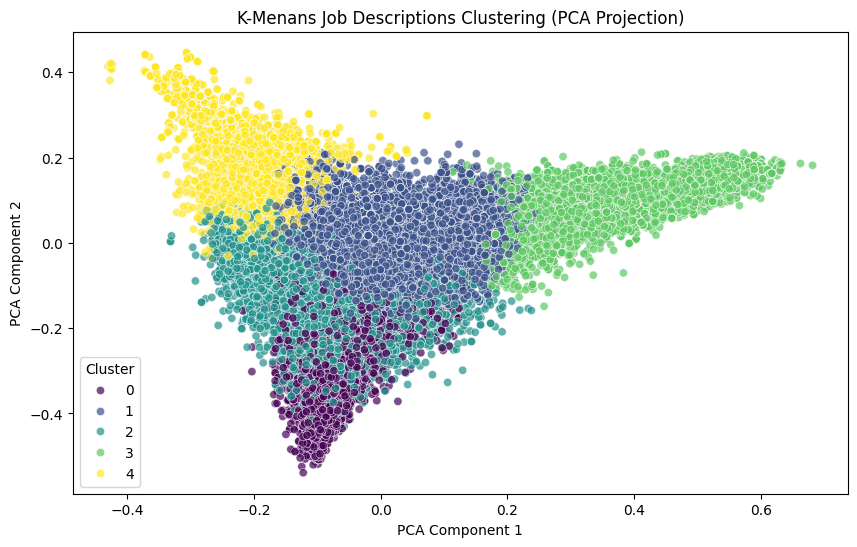

   Job.ID                                              Title  Cluster
0     111                               Server @ Tacolicious        1
1     113                   Kitchen Staff/Chef @ Claude Lane        1
2     117               Bartender @ Machka Restaurants Corp.        1
3     121                            Server @ Teriyaki House        1
4     127        Kitchen Staff/Chef @ Rosa Mexicano - Sunset        1
5     129              Receptionist @ Mind of Beauty Day Spa        1
6     131                      Server @ Roy's Woodland Hills        1
7     133                              Driver @ KoJa Kitchen        1
8  134273      Assistant Store Manager @ King's Food Markets        1
9  134274  Store Associate - Retail Sales (Customer Servi...        4


In [16]:
num_clusters = 5  # Define number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_jobs['Cluster'] = kmeans.fit_predict(X)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_jobs['Cluster'], palette="viridis", alpha=0.7)
plt.title("K-Menans Job Descriptions Clustering (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.show()

# Display Sample Results
print(df_jobs[['Job.ID', 'Title', 'Cluster']].head(10))

### 6. Inpterpret K- Means

In [17]:
# see words

In [18]:
from collections import Counter

# Function to extract most common words per cluster
def get_common_words_per_cluster(df, n_words=15):
    cluster_words = {}

    for cluster in df['Cluster'].unique():
        all_words = " ".join(df[df['Cluster'] == cluster]['Cleaned_Description']).split()
        word_freq = Counter(all_words).most_common(n_words)
        cluster_words[cluster] = [word for word, freq in word_freq]
    
    return cluster_words

# Get common words for each cluster
common_words = get_common_words_per_cluster(df_jobs)

# Display results
for cluster, words in common_words.items():
    print(f"Cluster {cluster}: {', '.join(words)}")

Cluster 1: service, work, job, customer, position, time, team, experience, duty, opportunity, must, required, company, skill, ability
Cluster 4: customer, sale, service, product, retail, store, work, opportunity, associate, experience, training, position, job, team, client
Cluster 3: care, patient, home, health, nurse, nursing, service, team, medical, work, plan, bayada, need, client, opportunity
Cluster 0: account, accounting, ref, payable, experience, per, clerk, email, accountant, position, company, payroll, please, entry, click
Cluster 2: ref, customer, per, id, classification, office, assistant, administrative, data, experience, service, position, call, skill, company


In [19]:
# make vis 

In [20]:
from collections import Counter

# Function to extract most common words per cluster
def get_common_words_per_cluster(df, n_words=15):
    cluster_words = {}

    for cluster in df['Cluster'].unique():
        all_words = " ".join(df[df['Cluster'] == cluster]['Cleaned_Description']).split()
        word_freq = Counter(all_words).most_common(n_words)
        cluster_words[cluster] = [word for word, freq in word_freq]
    
    return cluster_words

# Get common words for each cluster
common_words = get_common_words_per_cluster(df_jobs)

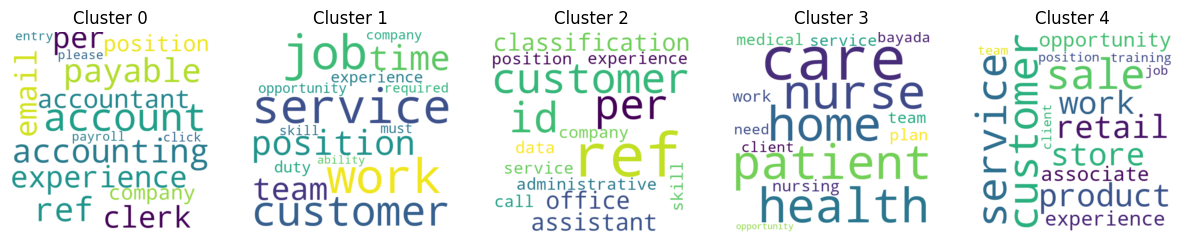

In [21]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sort clusters in ascending order (1-4)
sorted_common_words = dict(sorted(common_words.items()))

# Create word clouds for each cluster in correct order
fig, axes = plt.subplots(1, len(sorted_common_words), figsize=(15, 5))

for i, (cluster, words) in enumerate(sorted_common_words.items()):
    wordcloud = WordCloud(width=500, height=500, background_color='white').generate(" ".join(words))
    
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].axis("off")

plt.show()

- **Cluster 0 (Finance & Accounting)**  
This cluster is well-defined, containing terms like **accounting, payable, clerk, payroll, and accountant**. It clearly represents **financial and accounting roles**, such as bookkeepers, payroll specialists, and clerks handling financial records. The presence of **"email" and "ref"** might indicate some administrative job postings mixed in, but overall, the cluster is strong.

- **Cluster 1 (Customer Service & Support)**  
This cluster is performing well, with key words like **customer, service, job, team, work, and position**. It reflects roles related to **customer support, call center agents, and service representatives**. The diversity of words suggests a broad range of customer-facing roles, but the presence of **"time" and "required"** might mean some general job descriptions are also captured here.

- **Cluster 2 (Administrative & Office Work)**  
This cluster includes words like **office, assistant, administrative, id, and classification**, indicating that it represents **administrative and clerical jobs**. However, the appearance of **"per" and "ref"** suggests some data artifacts that may need further filtering. Otherwise, the cluster seems to be correctly grouping **office-related roles**.

- **Cluster 3 (Healthcare & Nursing)**  
This cluster is performing exceptionally well, with dominant words like **patient, nurse, care, health, home, and medical**. It clearly captures **nursing, caregiving, and medical assistant roles**, likely from hospitals, home care agencies, and clinics. There is very little noise in this cluster, making it one of the most accurate.

- **Cluster 4 (Retail & Sales Jobs)**  
This cluster is strong, with clear retail and sales-related words such as **product, store, customer, work, sale, and associate**. It effectively groups **retail store associates, sales representatives, and customer-facing retail jobs**. This cluster is well-separated and provides meaningful insights into **store-based roles**.


###  Part 1 Summary :
 - job clustering based on job descriptions (JD).
 - text preprocessing is applied using **NLTK** for tokenization, stopword removal, and lemmatization.
 - **TF-IDF vectorization** is used to convert text into numerical features.
 - The optimal number of clusters is determined using the **Elbow Method**
 -  followed by clustering with **K-Means**.
 - Finally, **word clouds and keyword extraction** are used to interpret the clusters.

**What Worked Well**  
Clusters **0 (Finance & Accounting), 3 (Healthcare & Nursing), and 4 (Retail & Sales)** were well-defined and meaningful, successfully grouping similar job roles together. Preprocessing steps like **lemmatization, stopword removal, and tokenization** improved the text clarity. The clustering effectively separated job categories, making interpretation straightforward.

**What Needs Improvement**  
Cluster 1 (Customer Service) is generally good but might still contain some general job descriptions, making it slightly broad. Cluster 2 (Administrative & Office Work) has minor noise, as words like "per" and "ref" should be further filtered out to remove irrelevant tokens. Some overlap between clusters, particularly between customer service and sales, suggests that additional refinement may be needed.


## Part 2 : GaussianMixture 

In [22]:
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
import numpy as np
import time
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
# Convert sparse matrix to dense format if needed
if isinstance(X, csr_matrix):  
    X_dense = X.toarray()
else:
    X_dense = X  # If already dense, use it directly

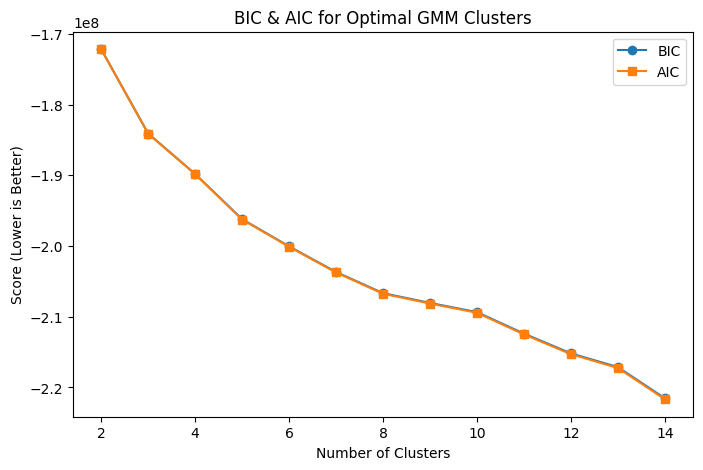

In [25]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

# Define range of clusters to test
cluster_range = range(2, 15)  # Test from 2 to 15 clusters
bic_scores = []
aic_scores = []

for k in cluster_range:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', random_state=42)
    gmm.fit(X_dense)  # Ensure X is dense
    bic_scores.append(gmm.bic(X_dense))
    aic_scores.append(gmm.aic(X_dense))

# Plot BIC and AIC to find the elbow
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, bic_scores, label="BIC", marker='o')
plt.plot(cluster_range, aic_scores, label="AIC", marker='s')
plt.xlabel("Number of Clusters")
plt.ylabel("Score (Lower is Better)")
plt.title("BIC & AIC for Optimal GMM Clusters")
plt.legend()
plt.show()

In [26]:
# Step 1: Convert Sparse Matrix to Dense Format
if isinstance(X, csr_matrix):  
    X_dense = X.toarray()
else:
    X_dense = X  # If already dense, use it directly

# Step 2: Define Number of Clusters
num_clusters = 4  # Set based on Elbow Method or prior knowledge
gmm = GaussianMixture(n_components=num_clusters, covariance_type='diag', random_state=42)

# Step 3: Apply GMM Clustering with Progress Bar
start_time = time.time()

with tqdm(total=X_dense.shape[0], desc="Running GMM") as pbar:
    df_jobs['GMM_Cluster'] = gmm.fit_predict(X_dense)
    pbar.update(X_dense.shape[0])

# Step 4: Print Elapsed Time
end_time = time.time()
print(f"GMM Clustering completed in {end_time - start_time:.2f} seconds")

# Step 5: Check Cluster Counts
unique_clusters, counts = np.unique(df_jobs['GMM_Cluster'], return_counts=True)
print("Cluster Counts:", dict(zip(unique_clusters, counts)))


Running GMM: 100%|██████████████████████| 84090/84090 [00:10<00:00, 7747.52it/s]

GMM Clustering completed in 10.86 seconds
Cluster Counts: {0: 17438, 1: 28053, 2: 18248, 3: 20351}


In [32]:
from sklearn.decomposition import PCA

# Ensure X is dense before applying PCA
X_dense = X.toarray() if hasattr(X, "toarray") else X  # Convert sparse matrix if needed

# Step 1: Perform PCA to reduce dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

# Step 2: Store PCA results in DataFrame
df_jobs["PCA1"] = X_pca[:, 0]
df_jobs["PCA2"] = X_pca[:, 1]


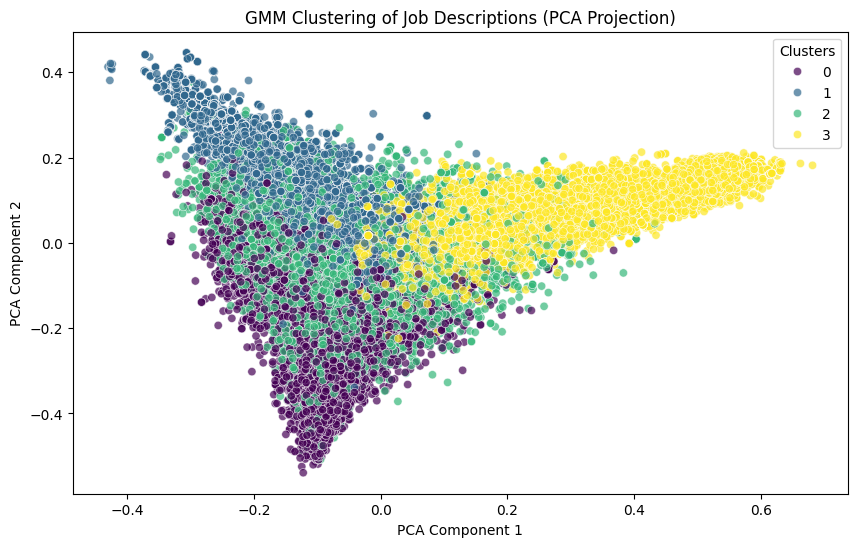

In [33]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    x="PCA1", 
    y="PCA2", 
    hue="GMM_Cluster", 
    data=df_jobs,
    palette="viridis", 
    alpha=0.7
)

plt.title("GMM Clustering of Job Descriptions (PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Clusters")
plt.show()

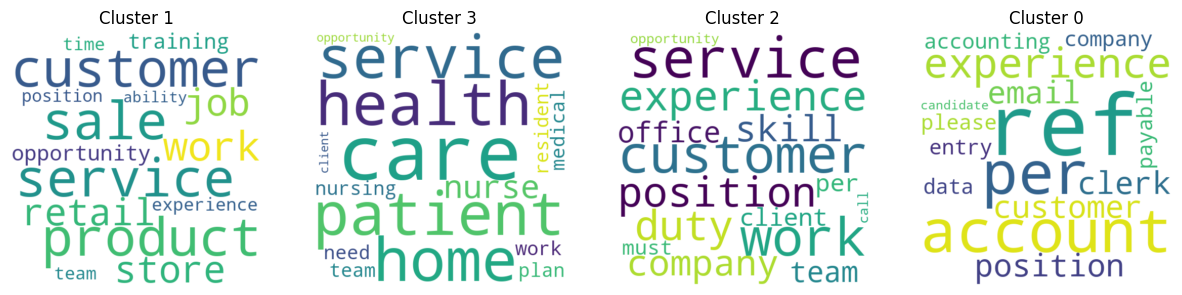

In [34]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Extract Common Words for Each GMM Cluster
def get_common_words_per_cluster(df, n_words=15):
    cluster_words = {}
    for cluster in df['GMM_Cluster'].unique():
        all_words = " ".join(df[df['GMM_Cluster'] == cluster]['Cleaned_Description']).split()
        word_freq = Counter(all_words).most_common(n_words)
        cluster_words[cluster] = [word for word, freq in word_freq]
    return cluster_words

# Step 2: Get Words for Each GMM Cluster
common_words = get_common_words_per_cluster(df_jobs)

# Step 3: Create Word Clouds
fig, axes = plt.subplots(1, len(common_words), figsize=(15, 5))

for i, (cluster, words) in enumerate(common_words.items()):
    wordcloud = WordCloud(width=500, height=500, background_color="white").generate(" ".join(words))
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].axis("off")

plt.show()

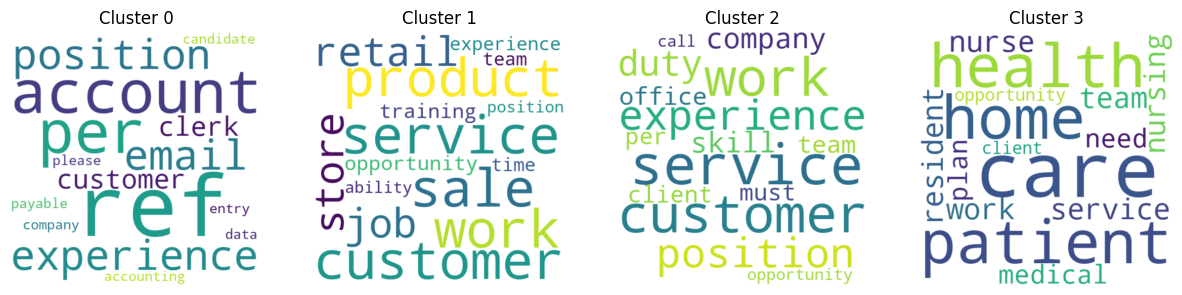

In [37]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Step 1: Extract Common Words for Each GMM Cluster
def get_common_words_per_cluster(df, n_words=15):
    cluster_words = {}
    for cluster in sorted(df['GMM_Cluster'].unique()):  # Ensure clusters are sorted numerically
        all_words = " ".join(df[df['GMM_Cluster'] == cluster]['Cleaned_Description']).split()
        word_freq = Counter(all_words).most_common(n_words)
        cluster_words[cluster] = [word for word, freq in word_freq]
    return cluster_words

# Step 2: Get Words for Each GMM Cluster
common_words = get_common_words_per_cluster(df_jobs)

# Step 3: Create Word Clouds in Correct Order
fig, axes = plt.subplots(1, len(common_words), figsize=(15, 5))

for i, cluster in enumerate(sorted(common_words.keys())):  # Ensure correct order
    words = common_words[cluster]
    wordcloud = WordCloud(width=500, height=500, background_color="white").generate(" ".join(words))
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].set_title(f"Cluster {cluster}")
    axes[i].axis("off")

plt.show()

In [ ]:
### ####